<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
# <center>Классификация групповых и одиночных целей
### <center> Автор: Мустаев Айрат (@airat)

## <center> Индивидуальный проект по анализу данных </center>

In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from scipy import signal
from scipy.signal import butter, lfilter, freqz
from numpy.fft import irfft,rfft, rfftfreq 
%matplotlib inline
import scipy.stats as sts
from pylab import *
from scipy import fft
from scipy import signal
import copy
from scipy.signal import hilbert, chirp

In [2]:
# -*- coding: utf-8 -*-
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['fft', 'copy', 'random', 'info', 'power', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [266]:
import copy
import seaborn as sns;
import itertools 

In [219]:
from sklearn.tree import DecisionTreeClassifier # Ваш код здесь
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

In [233]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score

In [264]:
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve


В проекте рассмотрим решение задачи классификации двух классов:
 * одиночный человек;
 * группа людей.
 
Исходными данными являются эксперементальные (сырые) данные, полученные с АЦП [(АЦП ЦАП Zet 230)](https://zetlab.com/shop/izmeritelnoe-oborudovanie/moduli-atsp-tsap/atsp-tsap-zet-230).

Под сырыми данными, понимаются синхронизированные по времени реализация (сейсмического сигнала) с частотой дискретизации Fs = 500 Гц. 

### Краткое описание природы данных

#### Сейсмическая волна
Сейсмическая волна - это волны, переносящие энергию упругих (механических) колебаний в горных породах. Источником сейсмической волны может быть землетрясение, взрыв, вибрация или <b>удар (в нашем случае проход объекта классификации)</b>. 
<p>Существует следующая классификация сейсмический волн:</p>
 * Объёмные волны - Объёмные волны проходят через недра Земли. Путь волн преломляется различной плотностью и жёсткостью подземных пород.
 * P-волны (первичные волны) — продольные, или компрессионные волны. Обычно их скорость в два раза быстрее S-волн, проходить они могут через любые материалы.
 * P- и S-волны в мантии и ядре.
 * Поверхностные волны несколько похожи на волны воды, но в отличие от них они путешествуют по земной поверхности. Их обычная скорость значительно ниже скорости волн тела. Из-за своей низкой частоты, времени действия и большой амплитуды они являются самыми разрушительными изо всех типов сейсмических волн.

Загрузим и рассмотрим исходные данные (сигналы) и их метаданные:

In [4]:
file_obj1 = open('file_signal/sig0002_20_1.txt', 'r')
data_s = file_obj1.read().split("\n")

Fs = 500.0

In [5]:
meta_data = pd.read_csv('metaTable_erase.csv', sep = ';')
meta_data.head()

,nameFile,Count,Steps
0,S140314_161345,1,6
1,S140314_161601,1,6
2,S140314_161839,1,6
3,S140314_162243,1,2
4,S140314_162358,1,6


где:
 * nameFile - название файла в котором закодирована дата и время записи сигнала;
 * Count - количество людей для проводилась запись сигнала;
 * Steps - количество проходов в рамках одной записи сигнала.

In [6]:
seism = {}  

for i in range(len(data_s)):
    sig_s = data_s[i].split('\t')[1]
    sig_s = list(map(lambda value: \
                float(value), 
                filter(lambda value2: value2 != '' and len(value2) > 0, 
                sig_s.split(';')
                )
    ))
    seism[data_s[i].split('\t')[0].upper()] = sig_s

name_signal = seism.keys()
name_signal = list(name_signal)
print('Количество реализаций - {}'.format(len(name_signal)))

Количество реализаций - 187


Рассмотрим реализацию сигнала, например для реализации = S140314_161345:

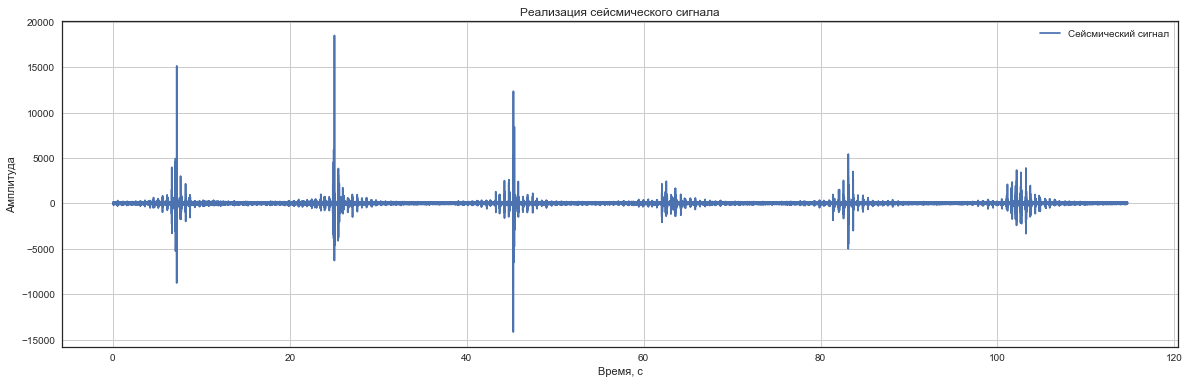

In [7]:
def plotSignal(nameEx):
    seismic_signal = seism[nameEx]
    time_x = np.linspace(0,len(seismic_signal)/Fs, len(seismic_signal))
    plt.figure(figsize = (20, 6))
    plt.title('Реализация сейсмического сигнала')
    plt.plot(time_x,seismic_signal, )
    plt.legend(['Сейсмический сигнал'])
    plt.xlabel('Время, с')
    plt.ylabel('Амплитуда')
    plt.grid()
    plt.show()

plotSignal('S140314_161345')

Данной реализации соответствует 6 проходов, для решения задачи классификации <b>требуется</b>:

 1. выделить соответсвующие проходы; 
 2. для проходов определить (расчитать) признаки;
 3. для сформированного признакового пространства добавить вектор меток.


##### 1. Выделение соответствующих проходов

Определим, что длительность прохода должна быть равной 8 секунд (<b>`step_time`</b>), то есть 4000 отсчетов. Визуализируем все реализации и оценим возможность обеспечить длительность прохода 8 с. 

В ходе рассмотрения установлено, что для корректного автоматизированного выделения проходов (<b>`selection_steps`</b>) требуется дополнительно модифицировать исходные данные, в части точного определения начала прохода (<b>`dop_group_steps`</b>): 

In [15]:
step_time = 8
len_step = step_time * Fs
print('Длительность прохода: {} отсчетов'.format(len_step))
count_steps = {}
for name in name_signal:
    if(meta_data[meta_data['nameFile'] == name].shape[0] > 0 and\
       meta_data[meta_data['nameFile'] == name].Steps.values[0] > 0):
        count_steps[name] = meta_data[meta_data['nameFile'] == name].Steps.values[0]
    else:
        name_signal.remove(name)

Длительность прохода: 4000.0 отсчетов


In [11]:
dop_group_steps = {}
dop_group_steps['S140507_180359'] = [8, 28, 48]
dop_group_steps['S140507_175631'] = [4, 16, 30]
dop_group_steps['S140507_175740'] = [3, 13, 23]
dop_group_steps['S140507_175116'] = [3, 15, 27]
dop_group_steps['S140507_180656'] = [6, 25, 44]
dop_group_steps['S140507_175227'] = [5, 19, 33]
dop_group_steps['S140507_181133'] = [6, 18, 28]
dop_group_steps['S140507_175006'] = [4, 17, 43]
dop_group_steps['S140507_175906'] = [6, 23, 41]
dop_group_steps['S140507_175445'] = [4, 16, 30]
dop_group_steps['S140507_180527'] = [6, 26, 43]
dop_group_steps['S140507_175536'] = [3, 13, 24]
dop_group_steps['S140507_180929'] = [4, 15, 26]
dop_group_steps['S140507_180021'] = [9, 26, 45]
dop_group_steps['S140507_180224'] = [8, 24, 44]
dop_group_steps['S140507_181031'] = [4, 17, 27]
dop_group_steps['S140507_170801'] = [8, 22, 48, 65]
dop_group_steps['S140507_172302'] = [9, 28, 50, 66]
dop_group_steps['S140507_171954'] = [3, 12, 25, 37]
dop_group_steps['S140507_170942'] = [8, 22, 42, 57]
dop_group_steps['S140507_174541'] = [8, 18, 35, 45]
dop_group_steps['S140507_181239'] = [4, 17, 30]
dop_group_steps['S140507_174732'] = []
dop_group_steps['S140507_171831'] = [3, 12, 25, 36]
dop_group_steps['S140507_171440'] = []
dop_group_steps['S140507_170319'] = [10, 25, 48, 68]
dop_group_steps['S140715_163612'] = []
dop_group_steps['S140507_178441'] = []
dop_group_steps['S140507_165507'] = [8, 28, 52, 72]
dop_group_steps['S140507_171708'] = [3, 14, 26, 37]
dop_group_steps['S140507_173900'] = [6, 21, 54, 75]
dop_group_steps['S140507_175999'] = []
dop_group_steps['S140507_173020'] = [2, 13, 24, 35]
dop_group_steps['S140507_171330'] = [2, 14, 27, 39]
dop_group_steps['S140507_171605'] = [1, 12, 25, 35]
dop_group_steps['S140507_170631'] = [6, 25.5, 48.5, 65.5]
dop_group_steps['S140507_171100'] = [7, 24, 46, 54.5]
dop_group_steps['S140507_172142'] = [8, 20, 44, 62]
dop_group_steps['S140507_165330'] = []
dop_group_steps['S140507_165315'] = [9, 30, 54, 72]
dop_group_steps['S140507_174319'] = [4, 15 ,33, 45]
dop_group_steps['S140507_165642'] = [10, 29, 52, 70.5]
dop_group_steps['S140507_174435'] = [5, 15, 33, 44]
dop_group_steps['S140507_172534'] = [4, 15, 26, 38]
dop_group_steps['S140507_172530'] = []
dop_group_steps['S140507_172832'] = [2, 13, 23, 35]
dop_group_steps['S140507_172731'] = [2, 12, 24, 35]
dop_group_steps['S140507_174039'] = [7, 24, 43, 57]
dop_group_steps['S140507_170459'] = [10, 26, 53, 68]
dop_group_steps['S140507_172926'] = [2, 12, 25, 35]
dop_group_steps['S140507_170006'] = [8, 31, 56, 74]
dop_group_steps['S140507_174213'] = [5, 15, 35, 46]

correct_group_count_step = dop_group_steps.keys()

In [19]:
def selection_steps(j,
                     signal,  
                     len_steps, 
                     count_steps, 
                     len_step):
    ind_low_steps = []

    le_ = 0
    fla = False
    for i in range(count_steps):
        
        max_val = np.max(signal[i*len_steps:(i+1)*len_steps])
        max_index = signal.index(max_val)
        low_index = int(max_index-len_step/2)
        high_index = int(max_index+len_step/2)
        if(low_index < 0):
            high_index = high_index - low_index
            low_index = 0
        sig_s = signal[low_index:high_index]
        if(sig_s.index(np.max(sig_s)) != len_step):
            delta = int(len_step / 2 - sig_s.index(np.max(sig_s)))
            low_index = low_index  - delta
            high_index = high_index - delta

        if(low_index < 0):
            high_index = high_index - low_index
            low_index = 0
        
        ind_low_steps.append(int(low_index)/500)
    return ind_low_steps

In [22]:
for name in name_signal:
    if(name not in correct_group_count_step):
        step = selection_steps(name, seism[name],
                                int(len(seism[name])/count_steps[name]), 
                                count_steps[name], len_step)
        dop_group_steps[name] = step
        
print ('Количество реализаций для которых определено начало прохода - {}.'.format(len(dop_group_steps)))

Количество реализаций для которых определено начало прохода - 160.


Соберем все данные в один класс и сформируем словарь экземпляров класса `my_signal` характеризующий  реализации сейсмических сигналов.

Обработаем сформированные данные: 
 - центрируем сигнал;
 - применяем фильтр (ФНЧ и ПФ);
 - нормируем сигнал.

In [130]:
class my_signal(object):
    """docstring"""
 
    def __init__(self, name, ind, ind_step, signal, targetCountN, fs, typeS):
        """Constructor"""
        self.name = name
        self.ind = ind
        self.ind_step = ind_step
        self.signal = signal
        self.flagN = -1
        self.step_time = -100500
        self.pause_time = -100500
        self.step_count = -100500
        self.period = -100500
        self.energy = -100500
        self.countPolin = -100500
        self.centr = 1
        if(targetCountN != -1):
            if(targetCountN == 1):
                self.targetCountN = u'Одиночный'
                self.flagN = 0
            else:
                self.targetCountN = u'Групповой'
                self.flagN = 1
        else:
            self.targetCountN = ''
            self.flagN = -1
        self.fs = fs
        self.typeS = typeS
    def info(self):
        print('--------------------------------')
        print('Название сигнала: {}'.format(self.name))
        print('Индекс сигнала в выборке: {}'.format(self.ind))
        print('Номер прохода в реализации: {}'.format(self.ind_step))
        print('Объект которому соответствует сигнал: {}'.format(self.targetCountN))
        print('Частота дискретизации сигнала: {}'.format(self.fs))
    # Визуализация сигнала во временной области    
    def plot_signal(self, 
                    size = (15, 6), 
                    delTime = 2,
                    nameFile = '',
                    dpi2 = 250,
                    color = 'r'):
        time_x = np.linspace(0,len(self.signal)/self.fs, len(self.signal))
        plt.title(u'Наименование :' + self.name + '\n ' + str(self.targetCountN) + ' ' + '\n')
        plt.plot(time_x,self.signal, color)
        plt.legend([self.typeS])
        plt.xlabel(u'Время, с')
        plt.ylabel(u'Амплитуда')
        plt.grid() 
        plt.savefig(nameFile, dpi = 250)
    # Визуализация спекта сигнала        
    def plot_spectrum(self, size = (15, 6), delFreq = 50):
        fig = plt.figure(figsize = size)
        plt.plot(self.frq,abs(self.spectr),'r')
        plt.title(u'Спектр сигнала')
        plt.xlabel(u'Частота (Гц)')
        plt.ylabel(u'|Y(freq)|')
        ax = fig.gca()
        ax.set_xticks(numpy.arange(0, int(self.fs/2), delFreq))
        plt.grid()   
    # Вычисление спекта сигнала            
    def creat_spectrum(self):
        n = len(self.signal) # Длительность сигнала
        k = arange(n)
        T = n/self.fs
        frq = k/T 
        frq = frq[range(int(n/2))] # Диапазон частот

        Y = np.fft(self.signal)/n # Вычисление быстрого преобразования Фурье и его нормализация
        Y = np.abs(Y[range(int(n/2))])
        self.spectr = Y
        self.frq = frq
    # Фильтрация сигнала (ФНЧ, ФВЧ, полосовой фильтр и режекторный фильтр)             
    def signal_filter(self, cutoff, order=5, btypeFilter = 'low'):
        self2 = copy.copy(self)
        nyq = 0.5 * self.fs
        if((btypeFilter == 'low') or (btypeFilter == 'highpass')):
            normal_cutoff = cutoff / nyq
            b, a = signal.butter(order, normal_cutoff, btype = btypeFilter, analog=False)
        elif((btypeFilter == 'bandpass') or (btypeFilter == 'bandstop')):
            normal_cutoff = [cutoff[0]/nyq, cutoff[1]/nyq]
            b, a = signal.butter(order, normal_cutoff, btype=btypeFilter, analog=False)
        self2.signal = signal.lfilter(b, a, self.signal)
        return self2

    def operation_erase_mean(self):
        me = np.mean(self.signal) 
        self.signal = self.signal - me
    # Нормировка сигнала    
    def operation_norm(self):
        self.signal = self.signal / np.max(np.abs(self.signal))
        
    def operation_high_low(self):
        

        p75 = np.percentile(self.signal, 75)
        p25 = np.percentile(self.signal, 25)

        qr = p75 - p25

        self.high = p75 + 1.5 * qr
        self.low = p25 - 1.5 * qr
        
    def operation_set_high_low(self, high, low):
        self.high = high
        self.low = low 

In [131]:
%%time

big_seism = {}

for name in dop_group_steps:
    if(len(dop_group_steps[name]) > 0):
        temp_meta = meta_data[meta_data['nameFile'] == name]
        sig_s_big = my_signal(name=name,
                         ind = temp_meta.index.values[0],
                         ind_step = 0,
                         signal = seism[name],
                         targetCountN = temp_meta.Count.values[0],
                         fs = Fs,
                         typeS = 'Сейсмический сигнал')
        sig_s_big = sig_s_big.signal_filter(btypeFilter='low', cutoff= 35)
        sig_s_big = sig_s_big.signal_filter(btypeFilter='bandstop', cutoff= [45, 55])
#         sig_s_big.operation_norm()
        sig_s_big.operation_high_low()
        big_seism[name]=sig_s_big

print ('Количество "больших" сигналов - {} реализаций.\n'.format(len(big_seism)))

Количество "больших" сигналов - 153 реализаций.

Wall time: 609 ms


Для примера визуализируем два экземпляра для первого и второго класса:

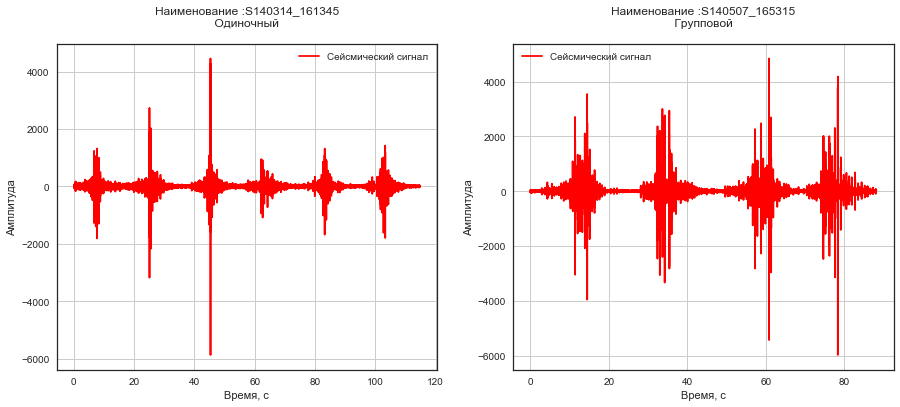

In [132]:
plt.figure(figsize = (15, 6))
subplot(1,2,1)
big_seism['S140314_161345'].plot_signal()
subplot(1,2,2)
big_seism['S140507_165315'].plot_signal()

Создадим новый словарь экземпляров класса `my_signal` для "малых" сигналов - проходов.

In [133]:
%%time

small_seism = []

for (j,name) in enumerate(big_seism.keys()):
    sig = big_seism[name]

    temp_meta = meta_data[meta_data['nameFile'] == sig.name]

    for (i, ind) in enumerate(dop_group_steps[sig.name]):

        if(len(dop_group_steps[sig.name]) > 0):
            sig_s_small = my_signal(name=sig.name,
                             ind = sig.ind,
                             ind_step = i,
                             signal = sig.signal[int(ind*sig.fs):int((ind+8)*sig.fs)],
                             targetCountN = temp_meta.Count.values[0],
                             fs = sig.fs,
                             typeS = 'Сейсмический сигнал')
            
            sig_s_small.operation_erase_mean()
            

            sig_s_small.operation_set_high_low(high=sig.high, low=sig.low)
            #sig_s_small.operation_high_low()
            #sig_s_small.feature_time(low_time = 50)

            
            small_seism.append(sig_s_small)

Wall time: 148 ms


In [138]:
print ('Количество "малых" сигналов - {} проходов.\n'.format(len(small_seism)))

Количество "малых" сигналов - 1329 проходов.



--------------------------------
Название сигнала: S140715_170222
Индекс сигнала в выборке: 161
Номер прохода в реализации: 0
Объект которому соответствует сигнал: Одиночный
Частота дискретизации сигнала: 500.0


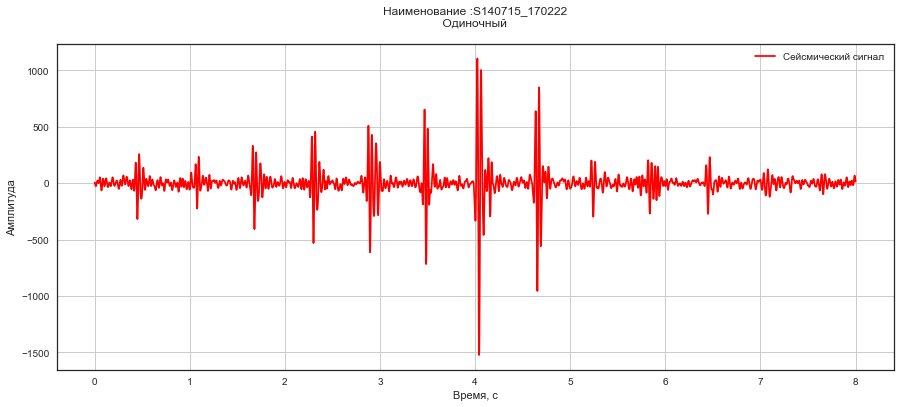

In [139]:
plt.figure(figsize = (15, 6))
small_seism[800].info()
small_seism[800].plot_signal()

##### 2. Для проходов определим (расчитаем) признаки:

 1. средняя длительность фазы переноса - период переноса ноги;
 2. средняя длительность фазы опоры - постановка ноги на опору;
 3. средняя длительность полного цикла (период двойного шага) - слагается для каждой ноги из фазы опоры и фазы переноса конечности;
 4. энергия сигнала;
 5. количество шагов.

Для расчета 1,2,3 и 5 признака требуется выделить из прохода фазу переноса или фазу опоры.  

In [48]:
indEx = 800
seismic_signal = small_seism[indEx].signal
N = len(seismic_signal)
step_pause = [0] * len(seismic_signal)

st = [0] * N

p75 = np.percentile(seismic_signal, 75)
p25 = np.percentile(seismic_signal, 25)

qr = p75 - p25
high = p75 + 1.5 * qr
low = p25 - 1.5 * qr

for j in range(len(seismic_signal)-1):
    i = j + 1
    if(seismic_signal[i] >= high or seismic_signal[i] <= low):
        st[i] = 1
        step_pause[i] = seismic_signal[i]


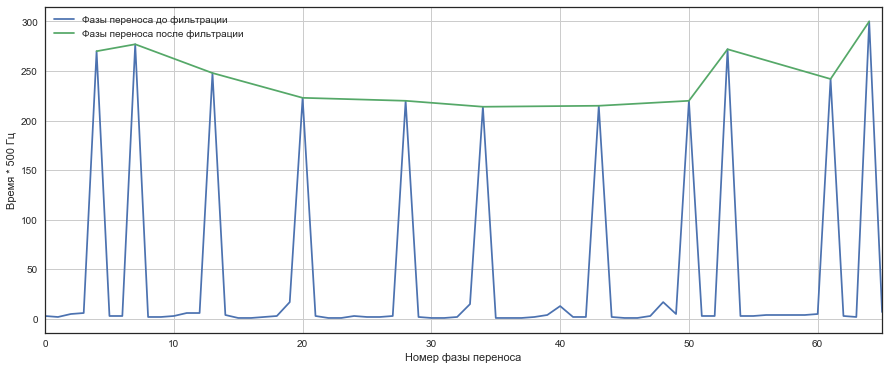

In [49]:
fig = plt.figure(figsize = (15, 6))
stepsS = pd.DataFrame()
for i in range(len(st)-1):
    if(st[i] == 0 and st[i+1] == 1 and len(stepsS) > 0):
        stepsS.set_value(len(stepsS)-1,'finish', (i))
    elif(st[i] == 1 and st[i+1] == 0):
        stepsS.set_value(len(stepsS),'start', i)
stepsS = stepsS[:-1]
stepsS['time_pause'] = stepsS['finish'] - stepsS['start']
stepsS['time_pause'].plot()
stepsS = stepsS[(stepsS['time_pause']>50)]
stepsS['time_pause'].plot()
plt.legend(['Фазы переноса до фильтрации', 'Фазы переноса после фильтрации'])
plt.xlabel(u'Номер фазы переноса')
plt.ylabel(u'Время * 500 Гц')
stepsS['time_pause'].median()
plt.grid()

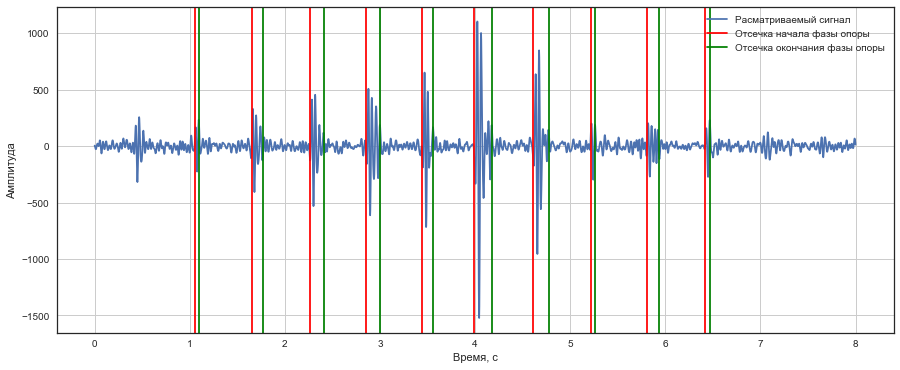

In [50]:
walk = []
fig = plt.figure(figsize = (15, 6))
#plt.plot(seismic_signal_by_filter_30)
time_x = np.linspace(0,len(seismic_signal)/Fs, len(seismic_signal))
plt.plot(time_x, seismic_signal)
for i in range(stepsS.shape[0]-1):
    plt.axvline(stepsS.iloc[i]['finish']/Fs, color = 'red')
    plt.axvline(stepsS.iloc[i+1]['start']/Fs, color = 'green')
    
    stepsS.set_value(stepsS.index[i],'time_walk',stepsS.iloc[i+1]['start'] - stepsS.iloc[i]['finish'])
plt.legend(['Расматриваемый сигнал', 'Отсечка начала фазы опоры', 'Отсечка окончания фазы опоры'])
plt.xlabel(u'Время, с')
plt.ylabel(u'Амплитуда')
plt.grid()

Таким образом разработан механизм выделения фазы переноса и опоры. 

Добавим в сформированный класс метод по выделению признаков -  <b>`feature_time`</b>.

In [140]:
class my_signal(object):
    """docstring"""
 
    def __init__(self, name, ind, ind_step, signal, targetCountN, fs, typeS):
        """Constructor"""
        self.name = name
        self.ind = ind
        self.ind_step = ind_step
        self.signal = signal
        self.flagN = -1
        self.step_time = -100500
        self.pause_time = -100500
        self.step_count = -100500
        self.period = -100500
        self.energy = -100500
        self.countPolin = -100500
        self.centr = 1
        if(targetCountN != -1):
            if(targetCountN == 1):
                self.targetCountN = u'Одиночный'
                self.flagN = 0
            else:
                self.targetCountN = u'Групповой'
                self.flagN = 1
        else:
            self.targetCountN = ''
            self.flagN = -1
        self.fs = fs
        self.typeS = typeS
    def info(self):
        print('--------------------------------')
        print('Название сигнала: {}'.format(self.name))
        print('Индекс сигнала в выборке: {}'.format(self.ind))
        print('Номер прохода в реализации: {}'.format(self.ind_step))
        print('Объект которому соответствует сигнал: {}'.format(self.targetCountN))
        print('Частота дискретизации сигнала: {}'.format(self.fs))
        
    def plot_signal(self, 
                    size = (15, 6), 
                    delTime = 2,
                    nameFile = '',
                    dpi2 = 250,
                    color = 'r'):
        time_x = np.linspace(0,len(self.signal)/self.fs, len(self.signal))
        plt.title(u'Наименование :' + self.name + '\n ' + str(self.targetCountN) + ' ' + '\n')
        plt.plot(time_x,self.signal, color)
        plt.legend([self.typeS])
        plt.xlabel(u'Время, с')
        plt.ylabel(u'Амплитуда')

        plt.savefig(nameFile, dpi = 250)
            
    def plot_spectrum(self, size = (15, 6), delFreq = 50):
        fig = plt.figure(figsize = size)
        plt.plot(self.frq,abs(self.spectr),'r')
        plt.title(u'Спектр сигнала')
        plt.xlabel(u'Частота (Гц)')
        plt.ylabel(u'|Y(freq)|')
        ax = fig.gca()
        ax.set_xticks(numpy.arange(0, int(self.fs/2), delFreq))
        plt.grid()   
        
    def creat_spectrum(self):
        n = len(self.signal) # Длительность сигнала
        k = arange(n)
        T = n/self.fs
        frq = k/T 
        frq = frq[range(int(n/2))] # Диапазон частот

        Y = np.fft(self.signal)/n # Вычисление быстрого преобразования Фурье и его нормализация
        Y = np.abs(Y[range(int(n/2))])
        self.spectr = Y
        self.frq = frq
        
    def signal_filter(self, cutoff, order=5, btypeFilter = 'low'):
        self2 = copy.copy(self)
        nyq = 0.5 * self.fs
        if((btypeFilter == 'low') or (btypeFilter == 'highpass')):
            normal_cutoff = cutoff / nyq
            b, a = signal.butter(order, normal_cutoff, btype = btypeFilter, analog=False)
        elif((btypeFilter == 'bandpass') or (btypeFilter == 'bandstop')):
            normal_cutoff = [cutoff[0]/nyq, cutoff[1]/nyq]
            b, a = signal.butter(order, normal_cutoff, btype=btypeFilter, analog=False)
        self2.signal = signal.lfilter(b, a, self.signal)
        return self2
    
    def operation_erase_mean(self):
        me = np.mean(self.signal) 
        self.signal = self.signal - me
        
    def operation_norm(self):
        self.signal = self.signal / np.max(np.abs(self.signal))
        
    def print_features(self):
        
        print ('Средняя длительность шага:{}'.format(self.step_time))
        print ('Средняя длительность паузы:{}'.format(self.pause_time))
        print ('Количество шагов:{}'.format(self.step_count))
        print ('Энергия сигнала:{}'.format(self.energy))
    def operation_high_low(self):
        

        p75 = np.percentile(self.signal, 75)
        p25 = np.percentile(self.signal, 25)

        qr = p75 - p25

        self.high = p75 + 1.5 * qr
        self.low = p25 - 1.5 * qr
        
    def operation_set_high_low(self, high, low):
        self.high = high
        self.low = low 
    def feature_time(self, low_time):
        if(self.flagN != -1):
            
            N = len(self.signal)

            signal2 = self.signal

            
            st = [0] * N

            for j in range(N-1):
                i = j + 1
                if(signal2[i] >= self.high or signal2[i] <= self.low):
                    st[i] = 1
                else:
                    signal2[i] = 0    

            start = []
            finish = []
            for i in range(len(st)-1):
                if(st[i] == 0 and st[i+1] == 1 and len(start) > 0):
                    finish.append(i)
                elif(st[i] == 1 and st[i+1] == 0):
                    start.append(i)

            pause_time_2 = []
            finish_2 = []
            start_2 = []
            step_time_2 = []
            pause_time = list(map(lambda x: x[0] - x[1], zip(finish, start)))

            for i in range(len(pause_time)):
                if(pause_time[i] > low_time):
                    pause_time_2.append(pause_time[i])
                    finish_2.append(finish[i])
                    start_2.append(start[i])

            for i in range(len(pause_time_2)-1):
                step_time_2.append(start_2[i+1] - finish_2[i])

            pause_time = []
            finish = []
            start = []
            step_time = []
            period = []
            for i in range(len(pause_time_2)-1):
                if(pause_time_2[i] < 5000 and step_time_2[i] < 400 and step_time_2[i] > 2 ):
                    pause_time.append(pause_time_2[i])
                    finish.append(finish_2[i])
                    start.append(start_2[i])   
                    step_time.append(step_time_2[i])
                    period.append(step_time_2[i] + pause_time_2[i])

            self.step_time = np.mean(step_time)
            self.pause_time = np.mean(pause_time)
            self.step_count = len(step_time)
            self.period = np.mean(period)

            analytic_signal = hilbert(signal2)
            amplitude_envelope = np.abs(analytic_signal)
            signal2 = np.abs(signal2) / np.max(signal2)
            self.energy = np.sum(signal2)

Для всего словаря сигналов применим метод `feature_time`

In [141]:
%%time

small_seism_feature = []
for signal in small_seism:
    
    sig_s_small_feature = my_signal(name=signal.name,
                     ind = signal.ind,
                     ind_step = signal.ind_step,
                     signal = signal.signal,
                     targetCountN = signal.targetCountN,
                     fs = signal.fs,
                     typeS = signal.typeS)

    sig_s_small_feature.flagN = signal.flagN
    sig_s_small_feature.operation_set_high_low(high=signal.high, low=signal.low)
    
    sig_s_small_feature.feature_time(low_time = 50)

    small_seism_feature.append(sig_s_small_feature)
print ('Количество "малых" сигналов - {} проходов с извлеченными признаками.\n'.format(len(small_seism_feature)))    

Количество "малых" сигналов - 1329 проходов с извлеченными признаками.

Wall time: 3.65 s


##### 3. для сформированного признакового пространства добавить вектор меток.

Выделим из словаря сигналов необходимые признаки и сформируем DataFrame

In [186]:
X = pd.DataFrame()
X['step_time'] = list(map(lambda x: x.step_time, small_seism_feature))
X['pause_time'] = list(map(lambda x: x.pause_time, small_seism_feature))
X['step_count'] = list(map(lambda x: x.step_count, small_seism_feature))
X['energy'] = list(map(lambda x: x.energy, small_seism_feature))
X['target'] = list(map(lambda x: x.flagN, small_seism_feature))
X['period'] = list(map(lambda x: x.period, small_seism_feature))
X = X[X['target'] > -1]
X = X.dropna()
print ('Количество групповых целей в выборке {}'.format(X[X['target'] == 1].shape[0]))
print ('Количество одиночных целей в выборке {}'.format(X[X['target'] == 0].shape[0]))

Количество групповых целей в выборке 633
Количество одиночных целей в выборке 577


In [112]:
X.head()

,step_time,pause_time,step_count,energy,target,period
0,75.923077,210.846154,13,112.141172,1,286.769231
1,70.800000,172.866667,15,115.981093,1,243.666667
2,44.666667,250.250000,12,132.591536,1,294.916667
3,43.416667,188.000000,12,71.356639,1,231.416667
4,47.000000,120.600000,10,51.404280,1,167.600000


Визуализируем признаки

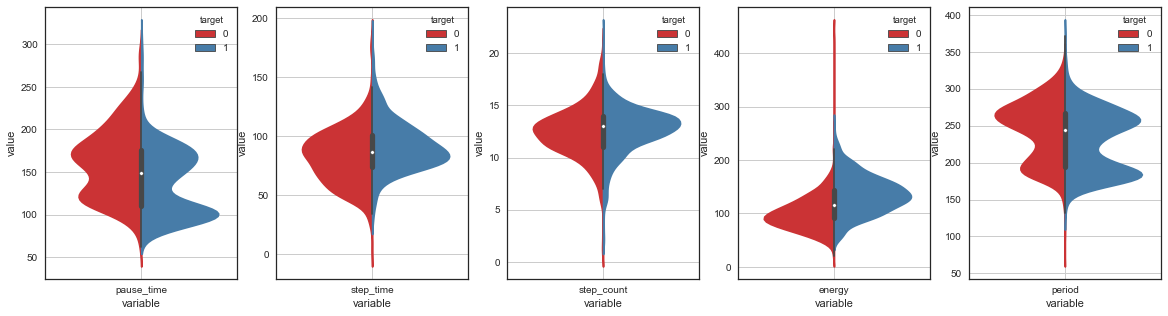

In [143]:
plt.figure(figsize(20, 5))
plt.subplot(1, 5, 1)
df = pd.melt(X, value_vars=['pause_time'], id_vars='target')
sns.violinplot(x='variable', y ='value', hue='target', data=df, scale ='count', split=True,palette="Set1")
plt.grid()
plt.subplot(1, 5, 2)
df = pd.melt(X, value_vars=['step_time'], id_vars='target')
sns.violinplot(x='variable', y ='value', hue='target', data=df, scale ='count', split=True,palette="Set1")
plt.grid()
plt.subplot(1, 5, 3)
df = pd.melt(X, value_vars=['step_count'], id_vars='target')
sns.violinplot(x='variable', y ='value', hue='target', data=df, scale ='count', split=True,palette="Set1")
plt.grid()
plt.subplot(1, 5, 4)
df = pd.melt(X, value_vars=['energy'], id_vars='target')
sns.violinplot(x='variable', y ='value', hue='target', data=df, scale ='count', split=True,palette="Set1")
plt.grid()
plt.subplot(1, 5, 5)
df = pd.melt(X, value_vars=['period'], id_vars='target')
sns.violinplot(x='variable', y ='value', hue='target', data=df, scale ='count', split=True,palette="Set1")
plt.grid()

Рассмотрим попарную корреляцию между признаками

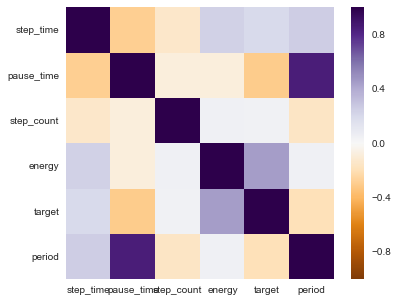

In [160]:
plt.figure(figsize(6, 5))
sns.heatmap(X.corr(), cmap='PuOr');

Заметим, что:
 * признаки step_time, pause_time сильно положительно коррелируют с признаком period;
 * признак pause_time отрицательно коррелирует с признаком energy.
 
Такие коэффициенты корреляции обусловлены природой формирования признакового пространства во временной области.

Кроме того, в рамках <b>исследования физиологии движений и физиологии активности</b>, Николай Александрович Бернштейн оценил, что при ходьбе в среднем темпе фаза опоры длится примерно 60 % от цикла двойного шага, фаза переноса примерно 40 %, оценим получившиеся данные. 

In [194]:
print('Средняя длительность двойного шага - {}'.format(np.round(X.period.mean(), 3)))
print('Средняя длительность фазы переноса - {} ({} % от цикла двойного шага)'.format(np.round(X.step_time.mean(),3), 
                                                                                     np.round(X.step_time.mean() / X.period.mean(), 3)))
print('Средняя длительность фазы опоры - {} ({} % от цикла двойного шага)'.format(np.round(X.pause_time.mean(),3), 
                                                                                     np.round(X.pause_time.mean() / X.period.mean(), 3)))

Средняя длительность двойного шага - 235.401
Средняя длительность фазы переноса - 87.507 (0.372 % от цикла двойного шага)
Средняя длительность фазы опоры - 147.894 (0.628 % от цикла двойного шага)


Представленные расчеты в целом совпадают с теоретическими результатами

In [ ]:
y = X['target']
X = X.drop('target', 1)

Сортировка признаков по информативности:
1. Признак -  energy (0.343930)
2. Признак -  pause_time (0.234516)
3. Признак -  period (0.174132)
4. Признак -  step_time (0.164603)
5. Признак -  step_count (0.082818)


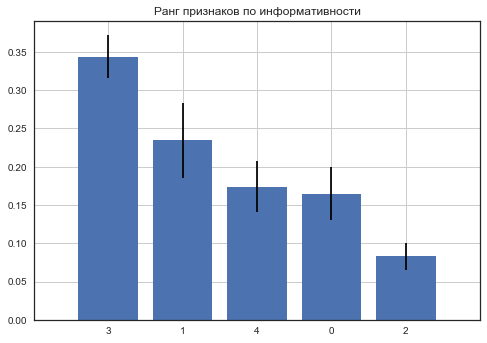

In [258]:
forest = RandomForestClassifier(n_estimators=40)

forest.fit(X,y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
ind = np.argsort(importances)[::-1]

# Print the feature ranking
print("Сортировка признаков по информативности:")

for f in range(X.shape[1]):
    print("%d. Признак -  %s (%f)" % (f + 1, X.columns[ind[f]], importances[ind[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Ранг признаков по информативности")
plt.bar(range(X.shape[1]), importances[indices],
       yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.grid()
plt.xlim([-1, X.shape[1]])
plt.show()

### Кросс-валидация

Разделим выборку на обучающую и тестовую

In [188]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                   stratify = y)

In [189]:
forest = RandomForestClassifier(n_estimators=500)
forest.fit(X_train, y_train)
test_pred = forest.predict(X_test)

In [195]:
accuracy_score(y_test, test_pred)

0.81542699724517909

In [197]:
y_test.value_counts()[0] / y_test.shape[0]

0.47658402203856748

In [259]:
f1_score(y_test, test_pred)

0.82597402597402603

Подберем параметры для модели

In [214]:
rf_tree_params = {'n_estimators': (50, 100, 150),
                  'min_samples_split' : list(range(1,5)),
               'max_depth': list(range(6,14))}
n_folds = 5

In [241]:
grid = GridSearchCV(clf, rf_tree_params, cv=n_folds, 
                    n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': (50, 100, 150), 'max_depth': [6, 7, 8, 9, 10, 11, 12, 13], 'min_samples_leaf': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [255]:
clf_best_score = grid.best_score_
clf_best_params = grid.best_params_
clf_best = grid.best_estimator_
mean_validation_scores = []
print("Лучший результат", clf_best_score)
print("лучшие параметры", clf_best_params)

Лучший результат 0.8028335301062574
лучшие параметры {'max_depth': 11, 'min_samples_leaf': 1, 'n_estimators': 100}


### Проверяем сходимость модели

In [250]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()
    plt.grid()

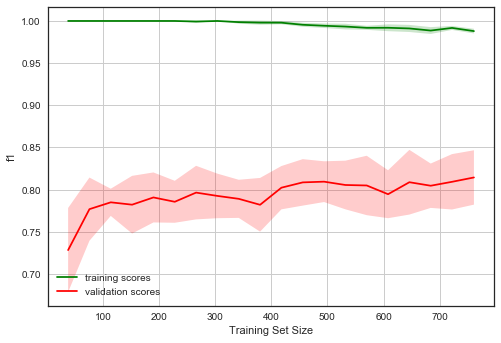

In [251]:
plot_learning_curve(RandomForestClassifier(n_estimators=clf_best_params['n_estimators'], 
                                           max_depth=clf_best_params['max_depth'], 
                                           min_samples_leaf=clf_best_params['min_samples_leaf']),
                   X_train, y_train, scoring='f1', cv=10)

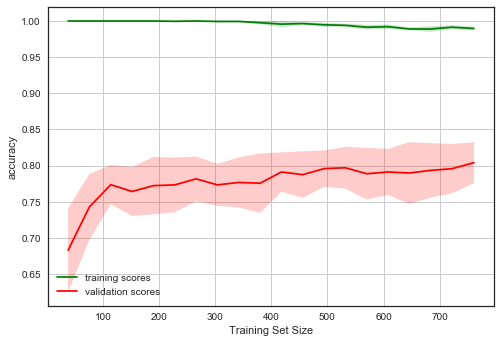

In [257]:
plot_learning_curve(RandomForestClassifier(n_estimators=clf_best_params['n_estimators'], 
                                           max_depth=clf_best_params['max_depth'], 
                                           min_samples_leaf=clf_best_params['min_samples_leaf']),
                   X_train, y_train, scoring='accuracy', cv=10)

Рассмотрим как влиет количетсво деревьев в модели 

In [268]:
def plot_validation_curve(clf, X, y, cv_param_name, 
                          cv_param_values, scoring):

    val_train, val_test = validation_curve(clf, X, y, cv_param_name,
                                           cv_param_values, cv=5,
                                                  scoring=scoring)
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')
    plt.xlabel(cv_param_name); plt.ylabel(scoring)
    plt.legend()
    plt.grid()

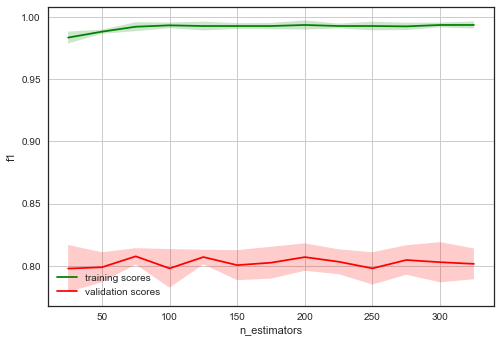

In [277]:
estimators = np.arange(25, 350, 25)
plot_validation_curve(RandomForestClassifier(min_samples_leaf=clf_best_params['min_samples_leaf'], 
                                             max_depth=clf_best_params['max_depth']), X_train, y_train, 
                      cv_param_name='n_estimators', 
                      cv_param_values= estimators,
                   scoring='f1')

Так же рассмотрим как влияет глубина деревьев на качество модели

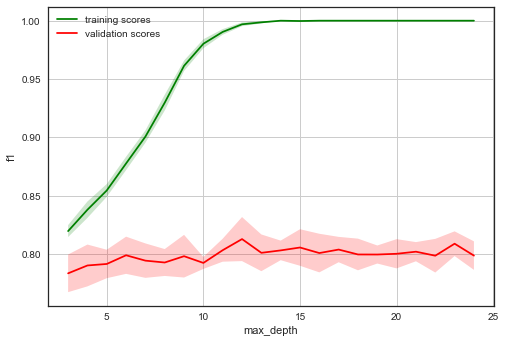

In [280]:
depth = np.arange(3, 25)
plot_validation_curve(RandomForestClassifier(n_estimators=clf_best_params['n_estimators'],
                                             min_samples_leaf=clf_best_params['min_samples_leaf']), X_train, y_train, 
                      cv_param_name='max_depth', 
                      cv_param_values= depth,
                   scoring='f1')

Заметим что:
 * на качество модели практически не влиется количество используемых деревьев;
 * нет смысла применять глубину больше 15.

In [279]:
release_forest = RandomForestClassifier(n_estimators=clf_best_params['n_estimators'], 
                                           max_depth=clf_best_params['max_depth'], 
                                           min_samples_leaf=clf_best_params['min_samples_leaf'])
release_forest.fit(X_train, y_train)
release_pred = release_forest.predict(X_test)
print('accuracy = {}'.format(accuracy_score(y_test, release_pred)))
print('f1 = {}'.format(f1_score(y_test, release_pred)))
print('roc_auc = {}'.format(roc_auc_score(y_test, release_pred)))

accuracy = 0.8099173553719008
f1 = 0.8217054263565893
roc_auc = 0.8085944630362033


### Выводы 

Рассмотрен полный цикл обработки и генерирования признаков из сейсмических сигналов.

Объем выборки составил более 1000 сигналов. Уникальных объектов (в данном случае людей по которым регистрировались сигналы) было более 10.

Признаки были сформированы во временной области, при дальнейшем исследовании планируется рассмотреть признаки из частотной области, отдельные гармоники или огибающие спектра.

Конечно для более точной классификации требуется больше самих сигналов, а также больше объектов.